# CAR-ML

## Importer biblioteker

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import time
import json
import joblib

## Last inn datasett

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Utforske og visualirere data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [4]:
train_df.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


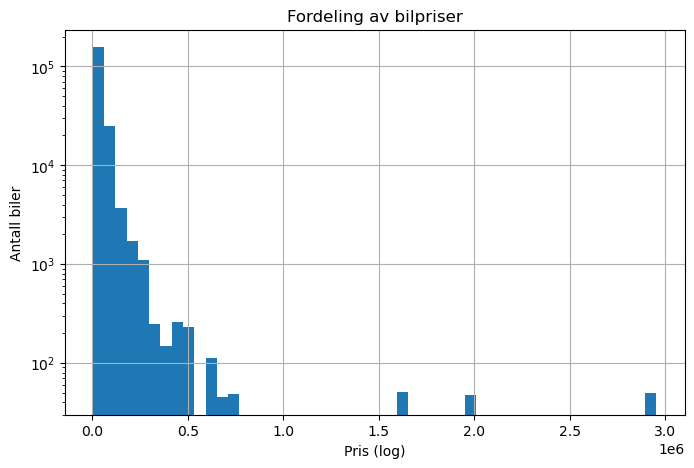

In [5]:
plt.figure(figsize=(8,5))
train_df["price"].hist(bins=50)
plt.yscale('log')
plt.xlabel("Pris (log)")
plt.ylabel("Antall biler")
plt.title("Fordeling av bilpriser")
plt.show()

## Finn og visualiser manglende verdier

In [6]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

clean_title    21419
fuel_type       5083
accident        2452
dtype: int64

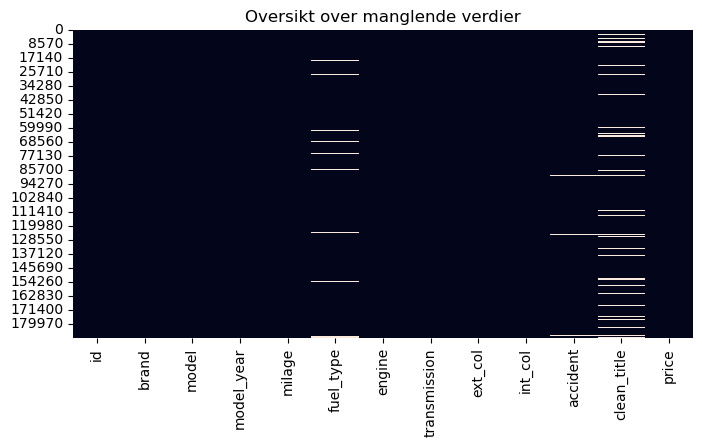

In [7]:
plt.figure(figsize=(8,4))
sns.heatmap(train_df.isnull(), cbar=False)
plt.title("Oversikt over manglende verdier")
plt.show()

## Se etter outliers og ekstreme verdier

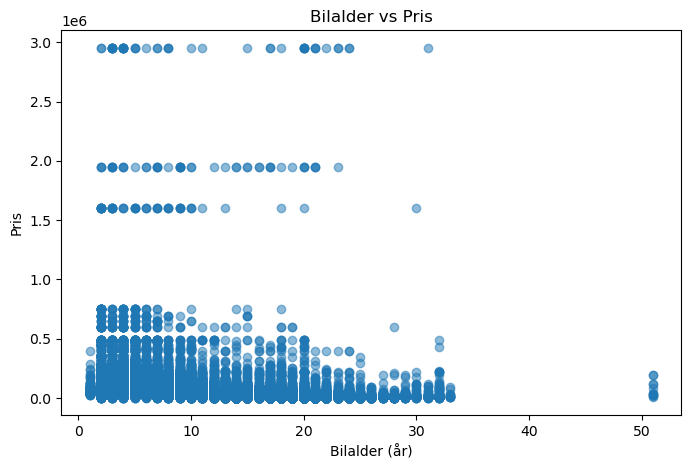

In [8]:
train_df["car_age"] = 2025 - train_df["model_year"]

plt.figure(figsize=(8,5))
plt.scatter(train_df["car_age"], train_df["price"], alpha=0.5)
plt.xlabel("Bilalder (år)")
plt.ylabel("Pris")
plt.title("Bilalder vs Pris")
plt.show()

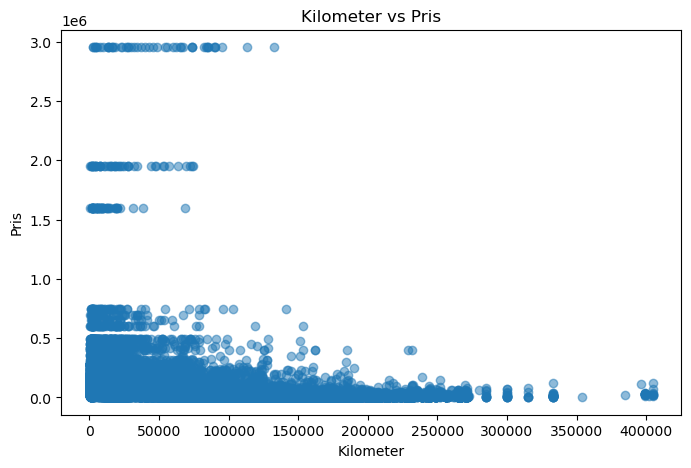

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(train_df["milage"], train_df["price"], alpha=0.5)
plt.xlabel("Kilometer")
plt.ylabel("Pris")
plt.title("Kilometer vs Pris")
plt.show()

## Justere data

#### Fjerne biler som koster over 1 million

In [10]:
train_df = train_df[train_df["price"] < 1000000]

#### Håndtere manglende verdier

In [11]:
train_df["clean_title"] = train_df["clean_title"].fillna("Unknown")
train_df["fuel_type"] = train_df["fuel_type"].fillna("Unknown")
train_df["accident"] = train_df["accident"].fillna("Unknown")

train_df.isnull().sum().sum()

np.int64(0)

#### Feature engineering

In [12]:
cat_cols = train_df.select_dtypes(include=["object"]).columns
print(cat_cols)

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')


In [13]:
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

#### Skalere de numeriske verdiene

In [14]:
num_cols = train_df.select_dtypes(include=["int64"]).columns.drop("price")

scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

## Velge og trene modell

In [15]:
X = train_df.drop("price", axis=1)
y = train_df["price"]

In [16]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### Linær Regresjon

In [17]:
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X, y, scoring=rmsle_scorer, cv=5)
print("Linær Regresjon RMSLE:", -lin_scores.mean())

Linær Regresjon RMSLE: 1.6028030904653636


### Beslutningstre Regresjon

In [18]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X, y, scoring=rmsle_scorer, cv=5)
print("Beslutningstre Regresjon RMSLE:", -tree_scores.mean())

Beslutningstre Regresjon RMSLE: 0.7100597328013007


### Random Forest Regresjon

In [19]:
forest_reg = RandomForestRegressor(random_state=42, n_estimators=100)
forest_scores = cross_val_score(forest_reg, X, y, scoring=rmsle_scorer, cv=5)
print("Random Forest Regresjon RMSLE:", -forest_scores.mean())

Random Forest Regresjon RMSLE: 0.5694891833386484


### Visualisering av RMSLE-scorene

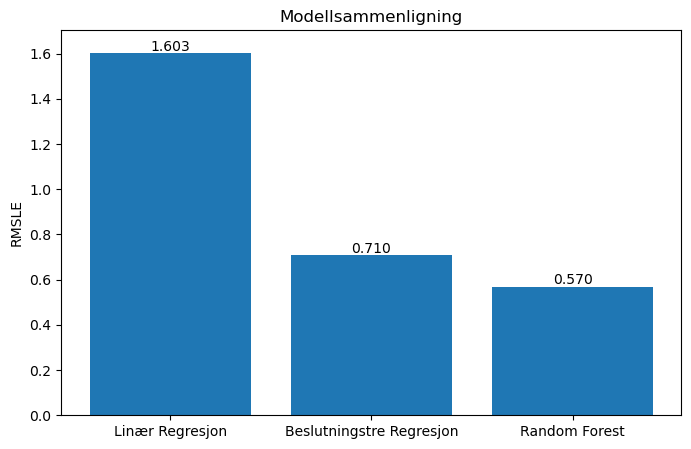

In [20]:
model_names = ["Linær Regresjon", "Beslutningstre Regresjon", "Random Forest"]
rmsle_scores = [1.6028, 0.7101, 0.5695]

plt.figure(figsize=(8,5))
plt.bar(model_names, rmsle_scores)
plt.ylabel("RMSLE")
plt.title("Modellsammenligning")
plt.ylim(0, max(rmsle_scores) + 0.1)

for i, score in enumerate(rmsle_scores):
    plt.text(i, score + 0.01, f"{score:.3f}", ha='center', fontsize=10)

plt.show()

## Finjuster modellen

### RandomizedSearchCV

In [25]:
N = 25000
X_small = X.sample(n=N, random_state=42)
y_small = y.loc[X_small.index]

param_dist = {
    "n_estimators": [100, 150, 200],
    "max_depth": [12, 16, 20],
    "max_features": ["sqrt", 0.4, 0.6],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [1, 2, 5],
    "bootstrap": [True],
}

In [26]:
rf = RandomForestRegressor(random_state=42,n_jobs=-1)

cv = KFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=12,            
    scoring=rmsle_scorer,
    cv=cv,         
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_small, y_small)

print("Beste parametere:")
print(random_search.best_params_)

print("\nBeste RMSLE (CV på subsample):")
print(-random_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Beste parametere:
{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.4, 'max_depth': 20, 'bootstrap': True}

Beste RMSLE (CV på subsample):
0.5354018320704298


### GridSearchCV

In [27]:
param_grid = {
    "n_estimators": [180, 200, 220],       
    "max_depth": [18, 20, 22],             
    "min_samples_split": [15, 20, 25],     
    "min_samples_leaf": [3, 5, 7],       
    "max_features": [0.3, 0.4, 0.5],       
    "bootstrap": [True],                   
}

rf2 = RandomForestRegressor(random_state=42, n_jobs=1)

grid_search = GridSearchCV(
    estimator=rf2,
    param_grid=param_grid,
    scoring=rmsle_scorer,  
    cv=cv,              
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_small, y_small)

print("Beste parametere:")
print(grid_search.best_params_)

print("\nBeste RMSLE (CV på subsample):")
print(-grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Beste parametere:
{'bootstrap': True, 'max_depth': 22, 'max_features': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 220}

Beste RMSLE (CV på subsample):
0.5328606476730201


## Tren endelig modell med beste parametere:

In [30]:
best_params = {
    "bootstrap": True,
    "max_depth": 22,
    "max_features": 0.3,
    "min_samples_leaf": 3,
    "min_samples_split": 20,
    "n_estimators": 250,
}
final_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    **best_params
)

final_rf.fit(X, y)     

,n_estimators,250
,criterion,'squared_error'
,max_depth,22
,min_samples_split,20
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,0.3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
joblib.dump(final_rf, "../models/random_forest_final.pkl")
with open("../models/feature_columns.json", "w", encoding="utf-8") as f:
    json.dump(list(X.columns), f, ensure_ascii=False, indent=2)

print("Ferdig")

Ferdig
